Number of the file to create

In [1]:
N = 6

<br>

In [2]:
import os
import numpy as np
import pandas as pd
import random
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from PIL import Image

In [3]:
random.seed(26)

In [4]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))

fix_layout()

In [5]:
def draw_labels(image, labels_df, thickness, color, fill_poly):
    for row in range(labels_df.shape[0]):
        pts = np.array(labels_df.loc[row]).reshape((-1,1,2))
        if fill_poly:
            image = cv.fillPoly(image, np.int32([pts]), color=rgb(color))
        else:
            image = cv.polylines(image, np.int32([pts]), True, color=rgb(color), thickness=thickness)
    
    return image

In [6]:
def rgb(hex_color):
    return tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))

In [7]:
thickness = 5
magnet_color = "#00cccc"
tissue_color = "#ff6666"

fill_poly = False

### Cropped Section Example

In [8]:
path_img= f"../augmented_dataset/wafer_cropped_3/extract/0.tif"
if os.path.isfile(path_img):
    section = cv.imread(path_img,0)
else:
    print ("The file " + path_img + " does not exist.")

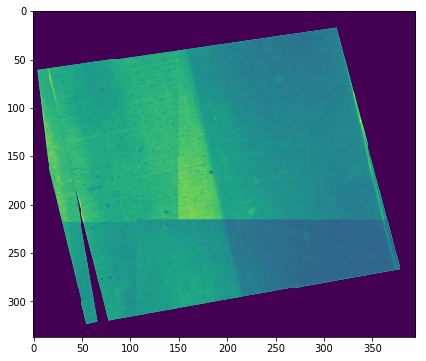

In [9]:
plt.figure(figsize=(8, 6))
plt.imshow(section)

In [10]:
section.shape

(337, 395)

In [11]:
height_section = section.shape[0]
width_section = section.shape[1]

In [12]:
init_img = np.zeros([height_section,width_section],dtype=np.uint8)
sub = init_img

In [13]:
# Boolean matrix which is true is not 0 (the pixel has a value, and is the potentially the object)
ind_true = section > 0

In [14]:
for i in range(height_section):
    for j in range(width_section):
        if(ind_true[i,j]):
            sub[i,j] = section[i,j]
        else:
            sub[i,j] = 255

In [15]:
for i in range(height_section):
    for j in range(width_section):
        if(sub[i,j] < 25):
            sub[i,j] = 122

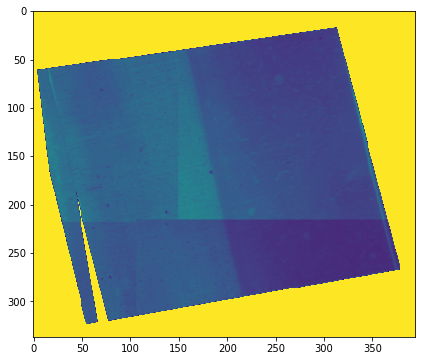

In [16]:
plt.figure(figsize=(8, 6))

plt.imshow(sub)

In [17]:
cv.imwrite("test.tif", sub)

True

### Load Segmentation Boxes 

To create artificial image we will load section with the associated segmentation boxes coordinates. 
In this example we're working only with the dataset1. Hence we load the seg. boxes for the dataset1.

In [18]:
index = pd.MultiIndex.from_tuples([('point_1', 'x'), ('point_1', 'y'), ('point_2', 'x'), ('point_2', 'y'),
                                   ('point_3', 'x'), ('point_3', 'y'), ('point_4', 'x'), ('point_4', 'y')])

In [19]:
boxes_tissues_dataset1 = pd.read_csv(f"../augmented_dataset/wafer_cropped_3/boxes_tissues.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
boxes_tissues_dataset1.head()

point_1      point_2      point_3      point_4     
        x    y       x    y       x    y       x    y
0     166   35     314   16     379  265     230  294
1     166   25     312   16     358  271     210  288
2     297  168     312  313      59  371      35  217
3     220  296      72  310      16   56     169   34
4     234  304      91  328      16   79     164   47

In [20]:
boxes_mag_dataset1 = pd.read_csv(f"../augmented_dataset/wafer_cropped_3/boxes_mag.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
boxes_mag_dataset1.head()

point_1      point_2      point_3      point_4     
        x    y       x    y       x    y       x    y
0      16   59     155   38     216  297      74  321
1      16   38     155   26     196  290      56  303
2     276   16     295  157      33  208      16   68
3     374  277     231  294     182   32     325   16
4     384  277     245  302     178   43     315   16

### Collision Detection

Method able to check only the interesting part of a section (not the background) and output the 'collision boxes' for this section.
We'll then be able to compare these collision boxes to check whether the section will collide with other sections in the full image

In [21]:
def get_collision_boxes(section,nb_boxes = 4, draw = False):
    #Divide the section into 5 block 
    height_section = section.shape[0]
    width_section = section.shape[1]
    
    
    limit_boxes = np.zeros([nb_boxes,4],dtype=np.uint8)
    
    cut_height = height_section//nb_boxes
    for cuts in range(nb_boxes):
        i=0
        
        # y Min
        for i in range(cut_height):
            if( (np.mean( section[i + cuts*cut_height] ) != 0)):
                limit_boxes[cuts,0] = i+cuts*cut_height
                break
        # y Max
        for i in range(cut_height):
            if(np.mean(section[(cuts+1)*cut_height-i-1]) != 0):
                limit_boxes[cuts,1] = (cuts+1)*cut_height-i
                break
        # x Min
        for i in range(width_section):
            if( np.mean( section[ cuts*cut_height+1 : (cuts+1)*cut_height , i] ) != 0):
                limit_boxes[cuts,2] = i
                break
        # x Max
        for i in range(width_section-1,0,-1):
            if(np.mean(section[cuts*cut_height+1:(cuts+1)*cut_height,i]) != 0):
                limit_boxes[cuts,3] = i
                break
        
        
        pts = np.array([limit_boxes[cuts,2],limit_boxes[cuts,0], limit_boxes[cuts,3],limit_boxes[cuts,0], limit_boxes[cuts,3],limit_boxes[cuts,1], limit_boxes[cuts,2],limit_boxes[cuts,1] ] )  
        if(draw):
            pts = pts.reshape((-1,1,2))
            section = cv.polylines(section, np.int32([pts]), True, color=rgb(tissue_color), thickness=1)
        
    return limit_boxes
        

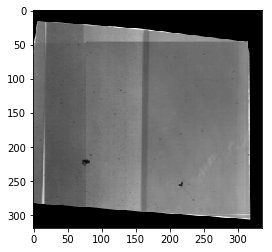

In [22]:
path_img= f"../augmented_dataset/wafer_cropped_3/extract/5.tif"
section = cv.imread(path_img,0)
plt.imshow(section, cmap='gray')

In [23]:
sections = get_collision_boxes(section,20,True)

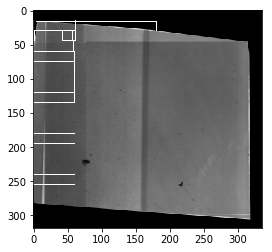

In [24]:
plt.imshow(section, cmap='gray')

In [25]:
sections

array([[  0,   0,   0,   0],
       [ 16,  30,   4, 180],
       [ 30,  45,   2,  57],
       [ 45,  60,   0,  59],
       [ 60,  75,   0,  60],
       [ 75,  90,   0,  60],
       [ 90, 105,   0,  60],
       [105, 120,   0,  60],
       [120, 135,   0,  60],
       [135, 150,   0,  61],
       [150, 165,   0,  61],
       [165, 180,   0,  61],
       [180, 195,   0,  61],
       [195, 210,   0,  61],
       [210, 225,   0,  61],
       [225, 240,   0,  61],
       [240, 255,   0,  61],
       [255,  14,   0,  61],
       [ 14,  29,   0,  62],
       [ 29,  44,  43,  62]], dtype=uint8)

### Create Artificial Image

Extract randomly section and place it randomly in the image. For each section, compute and store the segmentation boxes coordinates of the section (brain + mag)

In [26]:
# Size of the image 4160 × 3110
full_image = np.zeros([3110,4160],dtype=np.uint8)
full_image.fill(255)

# Nb of sections to put in the image
nb_sections = 300

# Nb of collision boxes to use
nb_collision_boxes = 30

<br>

In [27]:
f_seg_tissues_artif = open("../augmented_dataset/artificial_images/seg_tissues_artif_"+str(N)+".txt","w+")
f_seg_mag_artif= open("../augmented_dataset/artificial_images/seg_mag_artif_"+str(N)+".txt","w+")

for index_section in range(nb_sections):
    
    # Section selection
    # section_num will be use to load the data image, and to load the corrects segmentation boxes
    section_num = random.randint(0, 70)
    
    path_img= f"../augmented_dataset/wafer_cropped_3/extract/"+str(section_num)+".tif"
    section = cv.imread(path_img,0)
    if section is None:
        print('Error with section',str(section_num))
    height_section = section.shape[0]
    width_section = section.shape[1]
     
    xpos_section = random.randint(50, 3900)
    ypos_section = random.randint(50, 2900)
    
    collision_boxes_section = get_collision_boxes(section, nb_collision_boxes, False)
        
    free_place = True
    for i in range(nb_collision_boxes):
        # check collision box 1
        #if(all(collision_boxes_section[i] != 0)):
        if( (collision_boxes_section[i][0] != collision_boxes_section[i][1]) & (collision_boxes_section[i][2] != collision_boxes_section[i][3]) ):
            if(np.mean(full_image[ypos_section+collision_boxes_section[i][0]:ypos_section+collision_boxes_section[i][1], xpos_section+collision_boxes_section[i][2]:xpos_section+collision_boxes_section[i][3]]) != 255):
                free_place = False
 
    # Find an area in the image free (all pixels = 255)
    timeout = 0    
    
    while(free_place == False):
        xpos_section = random.randint(50, 3900)
        ypos_section = random.randint(50, 2900)
        
        free_place = True
        for i in range(nb_collision_boxes):
            # check collision box 1
             #if(all(collision_boxes_section[i] != 0)):
            if( (collision_boxes_section[i][0] != collision_boxes_section[i][1]) & (collision_boxes_section[i][2] != collision_boxes_section[i][3]) ):
                if(np.mean(full_image[ypos_section+collision_boxes_section[i][0]:ypos_section+collision_boxes_section[i][1], xpos_section+collision_boxes_section[i][2]:xpos_section+collision_boxes_section[i][3]]) != 255):
                    free_place = False

        if(timeout>10000):
            # end loop no more space
            index_section = nb_sections+1 
            print("No more space")
            break
        else:
            timeout= timeout+1
    
    if(timeout > 10000):
        break
    
    sub = full_image[ypos_section : ypos_section+height_section, xpos_section:xpos_section+width_section]

    # Integrate the section into the full image
    for i in range(height_section):
        for j in range(width_section):
            if(section[i,j] != 0):
                sub[i,j] = section[i,j]

    
    # Smoother border
    for i in range(height_section):
        for j in range(width_section):
            if(sub[i,j] < 25):
                sub[i,j] = 122
    
    #Store the new segmentation position Brain tissues
    temp_tissue = boxes_tissues_dataset1.iloc[section_num]
    
    seg_tissues_p1_x = temp_tissue['point_1']['x'] + xpos_section  
    seg_tissues_p1_y = temp_tissue['point_1']['y'] + ypos_section  
    
    seg_tissues_p2_x = temp_tissue['point_2']['x'] + xpos_section  
    seg_tissues_p2_y = temp_tissue['point_2']['y'] + ypos_section  
    
    seg_tissues_p3_x = temp_tissue['point_3']['x'] + xpos_section  
    seg_tissues_p3_y = temp_tissue['point_3']['y'] + ypos_section 
    
    seg_tissues_p4_x = temp_tissue['point_4']['x'] + xpos_section 
    seg_tissues_p4_y = temp_tissue['point_4']['y'] + ypos_section 
    
    f_seg_tissues_artif.write("%d,%d\t%d,%d\t%d,%d\t%d,%d\r\n" % (seg_tissues_p1_x,seg_tissues_p1_y,  seg_tissues_p2_x,seg_tissues_p2_y,  seg_tissues_p3_x,seg_tissues_p3_y,  seg_tissues_p4_x,seg_tissues_p4_y))
    
    #Store the new segmentation position Mag 
    temp_mag = boxes_mag_dataset1.iloc[section_num]
    
    seg_mag_p1_x = temp_mag['point_1']['x'] + xpos_section  
    seg_mag_p1_y = temp_mag['point_1']['y'] + ypos_section  
    
    seg_mag_p2_x = temp_mag['point_2']['x'] + xpos_section  
    seg_mag_p2_y = temp_mag['point_2']['y'] + ypos_section  
    
    seg_mag_p3_x = temp_mag['point_3']['x'] + xpos_section  
    seg_mag_p3_y = temp_mag['point_3']['y'] + ypos_section 
    
    seg_mag_p4_x = temp_mag['point_4']['x'] + xpos_section 
    seg_mag_p4_y = temp_mag['point_4']['y'] + ypos_section 
    
    f_seg_mag_artif.write("%d,%d\t%d,%d\t%d,%d\t%d,%d\r\n" % (seg_mag_p1_x,seg_mag_p1_y,  seg_mag_p2_x,seg_mag_p2_y,  seg_mag_p3_x,seg_mag_p3_y,  seg_mag_p4_x,seg_mag_p4_y))
    
f_seg_tissues_artif.close()
f_seg_mag_artif.close()

TypeError: randint() missing 1 required positional argument: 'b'

In [ ]:
plt.figure(figsize=(15, 7))

plt.imshow(full_image)

In [ ]:
cv.imwrite("test_artificial_images.tif", full_image)

### Add Background

In [ ]:
path_img= f"../augmented_dataset/background_1.tif"
if os.path.isfile(path_img):
    backgnd = cv.imread(path_img, 0)
else:
    print ("The file " + path_img + " does not exist.")

In [ ]:
plt.imshow(backgnd, cmap='gray')

In [ ]:
width_subbckgnd = backgnd.shape[1]
height_subbckgnd = backgnd.shape[0]

for ind_y in range(10):
    for ind_x in range(10):
        #No objects on the complete background gridcell
        if(np.mean(full_image[backgnd.shape[0]*ind_y:backgnd.shape[0]*(ind_y+1),backgnd.shape[1]*ind_x:backgnd.shape[1]*(ind_x+1)]) == 255):
            full_image[backgnd.shape[0]*ind_y:backgnd.shape[0]*(ind_y+1),backgnd.shape[1]*ind_x:backgnd.shape[1]*(ind_x+1)] =   backgnd
        
        else:
            for i in range(backgnd.shape[0]):
                for j in range(backgnd.shape[1]):
                    if(full_image[height_subbckgnd*ind_y + i , width_subbckgnd*ind_x + j] == 255):
                        full_image[height_subbckgnd*ind_y + i, width_subbckgnd*ind_x + j] = backgnd[i,j]
        

In [ ]:
plt.figure(figsize=(40, 30))
plt.imshow(full_image)

In [ ]:
cv.imwrite("test_wthbackground.tif", full_image)

### Segmentation 

Load segmentation boxes recently created for artificial image (brain + mag)

In [ ]:
seg_tissues_artif = pd.read_csv(f"../augmented_dataset/artificial_images/seg_tissues_artif_"+str(N)+".txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
seg_tissues_artif.head()

In [ ]:
seg_mag_artif = pd.read_csv(f"../augmented_dataset/artificial_images/seg_mag_artif_"+str(N)+".txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
seg_mag_artif.head()

In [ ]:
# Load recently created artificial images
path_img= f"test_wthbackground.tif"
if os.path.isfile(path_img):
    extrct_img = cv.imread(path_img)
else:
    print ("The file " + path_img + " does not exist.")

In [ ]:
extrct_img = draw_labels(extrct_img, seg_mag_artif, thickness, magnet_color, fill_poly)

In [ ]:
extrct_img = draw_labels(extrct_img, seg_tissues_artif, thickness, tissue_color, fill_poly)

In [ ]:
legend_elements = [Line2D([0], [0], color=magnet_color, lw=thickness, label='Magnet Part'),
                       Line2D([0], [0], color=tissue_color, lw=thickness, label='Brain Part')]

In [ ]:
plt.figure(figsize=(20, 15))
plt.imshow(extrct_img)

plt.legend(handles=legend_elements, loc='upper left', fontsize=20)



In [ ]:
cv.imwrite("../augmented_dataset/artificial_images/artificail_wafer_"+str(N)+".tif", full_image)